Задание

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

Визуальный анализ ряда
Стабилизация дисперсии (при необходимости)
Выбор порядка дифференцирования
Выбор начальных приближений для p,q,P,Q
Обучение и сравнение моделей-кандидатов, выбор победителя
Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.
Прогнозирование с помощью финальной модели.
Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

from calendar import monthrange

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [3]:
# читаем данные
data = pd.read_csv('WAG_C_M.csv',
                   sep = ';', 
                   index_col=['month'], 
                   parse_dates=['month'], 
                   dayfirst=True)

In [4]:
# смотрим на первые несколько строк
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


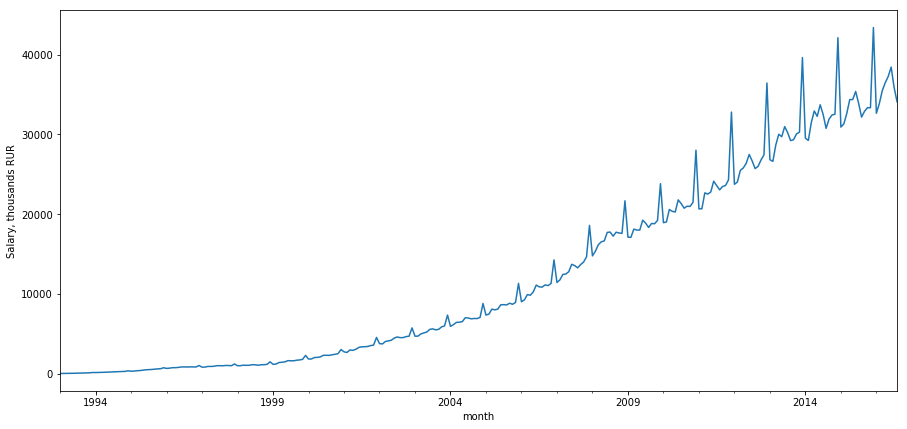

In [5]:
# отображаем данные
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('Salary, thousands RUR')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


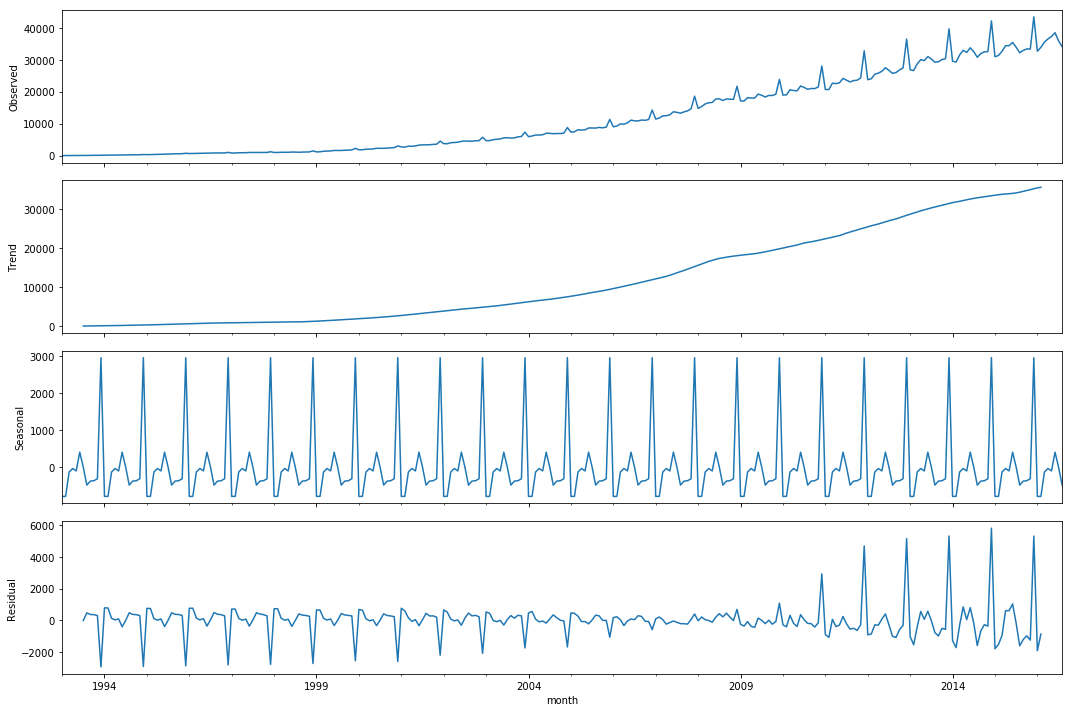

In [6]:

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Налицо нестационарность, тренд, сезонность и большая дисперсия

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


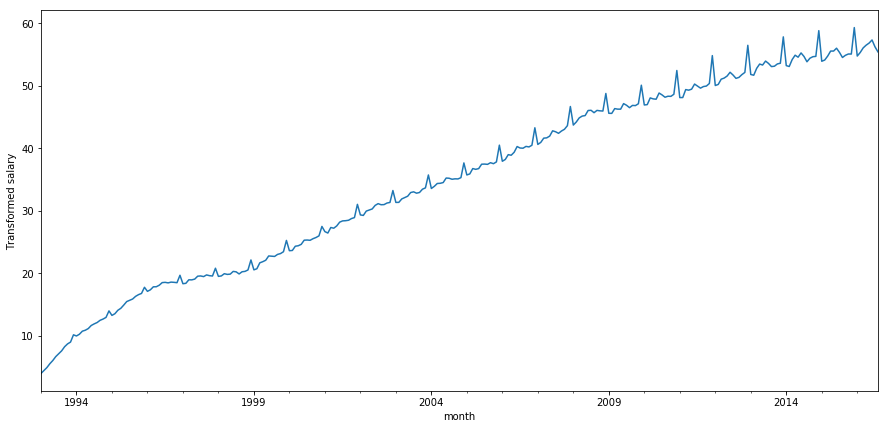

In [7]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel('Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и визуально в данных просматриваются тренд и сезонность. Будем убирать и сезонность, и тренд. Начнём с очевидного - годовой (12-месячной) сезонности.

Критерий Дики-Фуллера: p=0.014697


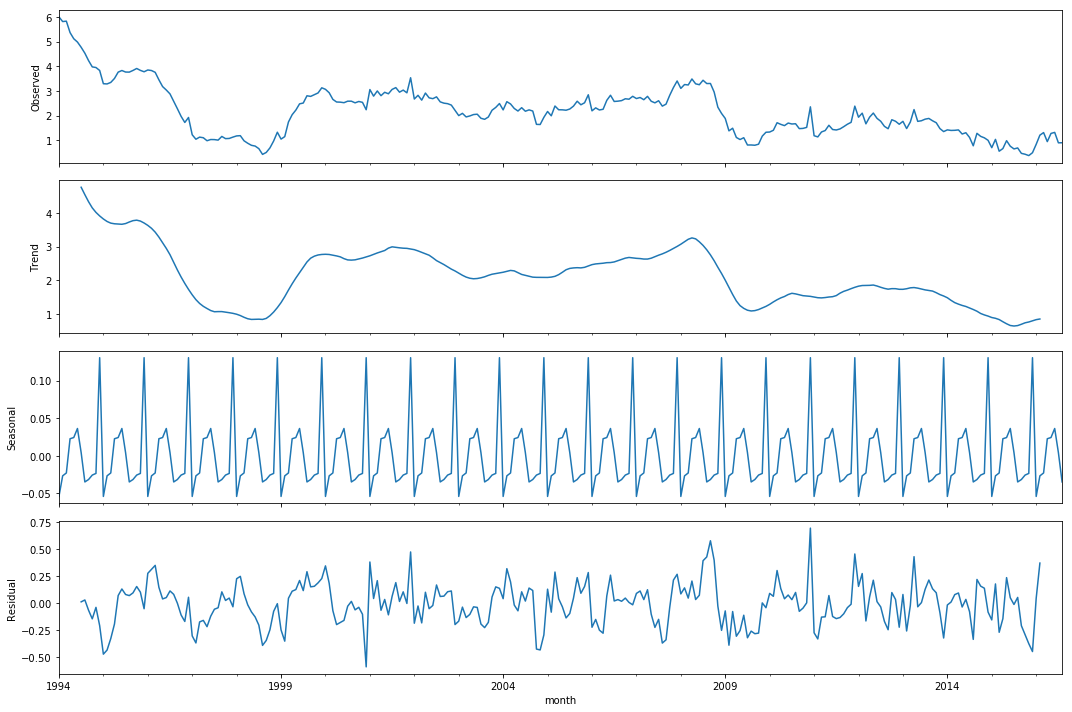

In [8]:
data['WAG_C_M_box_12Mdiff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_12Mdiff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_12Mdiff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности на урновне значимости 0.05, но график подсказывает, что полностью избавиться от убывающего тренда не удалось. Попробуем добавить ещё одно обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


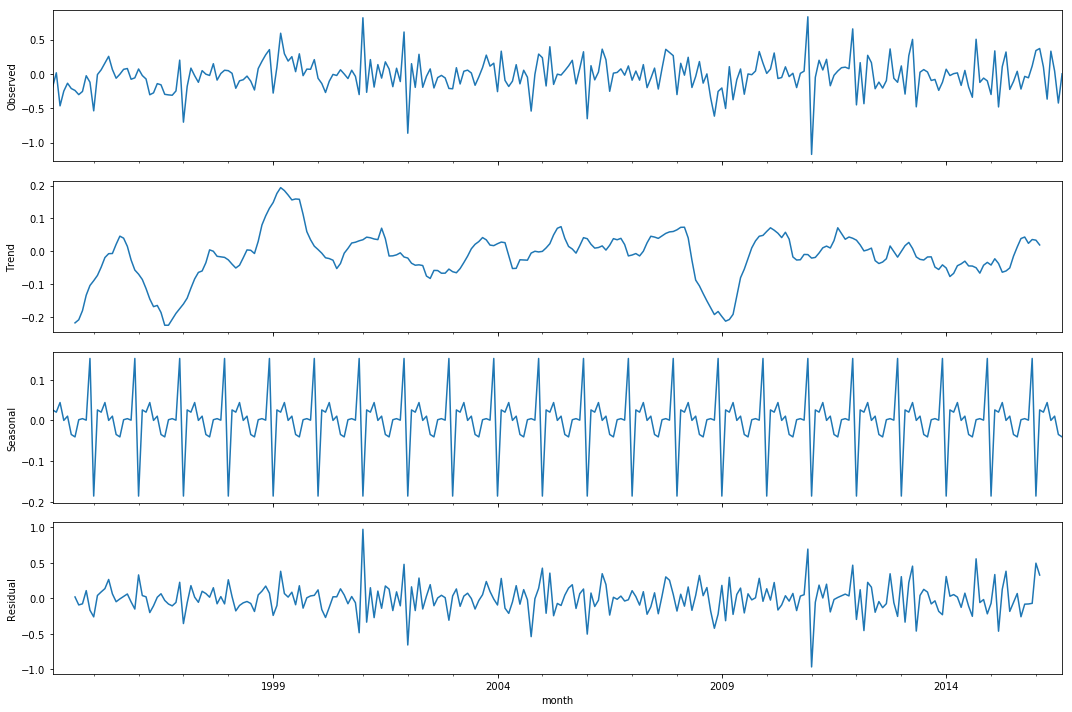

In [9]:
data['WAG_C_M_box_12Mdiff_1'] = data.WAG_C_M_box_12Mdiff - data.WAG_C_M_box_12Mdiff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_12Mdiff_1[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_12Mdiff_1[13:])[1])

Гипотеза нестационарности полностью отвергается, а тренда больше не видно.

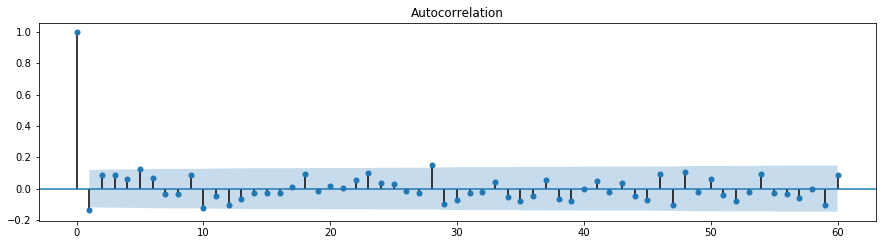

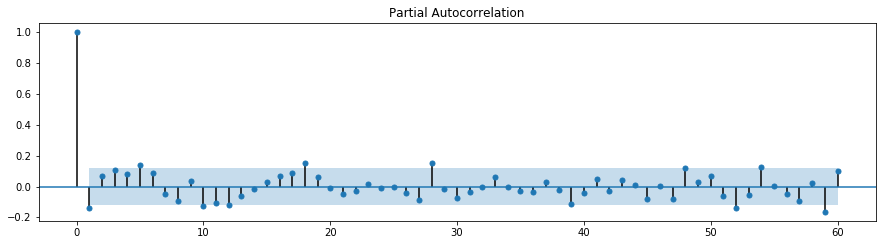

In [10]:
# Изучим ACF и PACF
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_12Mdiff_1[13:].values.squeeze(), lags=60, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_12Mdiff_1[13:].values.squeeze(), lags=60, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=5, P=0, p=5. На всякий случай, возьмём широкие диапазоны изменения метапараметров.

In [11]:
ps = range(4, 6)
d=1
qs = range(4, 6)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

Проверить нужно всего 36 моделей

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, 
                                          order = (param[0], d, param[1]), 
                                          seasonal_order = (param[2], D, param[3], 12)
                                         ).fit(disp = -1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 0, 1))
('wrong parameters:', (4, 4, 0, 2))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (4, 4, 1, 1))
('wrong parameters:', (4, 4, 1, 2))
('wrong parameters:', (4, 4, 2, 0))
('wrong parameters:', (4, 4, 2, 1))
('wrong parameters:', (4, 4, 2, 2))
('wrong parameters:', (5, 4, 0, 0))
('wrong parameters:', (5, 4, 0, 1))
('wrong parameters:', (5, 4, 0, 2))
('wrong parameters:', (5, 4, 1, 0))
('wrong parameters:', (5, 4, 1, 1))
('wrong parameters:', (5, 4, 1, 2))
('wrong parameters:', (5, 4, 2, 0))
('wrong parameters:', (5, 4, 2, 1))
('wrong parameters:', (5, 4, 2, 2))
Wall time: 3min 40s


In [18]:
# смотрим на AIC лучших результатов
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
12  (5, 5, 1, 0) -25.941353
10  (5, 5, 0, 1) -25.336406
15  (5, 5, 2, 0) -24.670412
13  (5, 5, 1, 1) -24.426892
11  (5, 5, 0, 2) -24.255229


In [19]:
# лучшая модель 
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.971
Date:                            Fri, 08 Sep 2017   AIC                            -25.941
Time:                                    16:19:29   BIC                             17.846
Sample:                                01-01-1993   HQIC                            -8.386
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0224      6.693      0.003      0.997     -13.095      13.140
ar.L2          0.0114      4.524   

Критерий Стьюдента: p=0.180258
Критерий Дики-Фуллера: p=0.000000


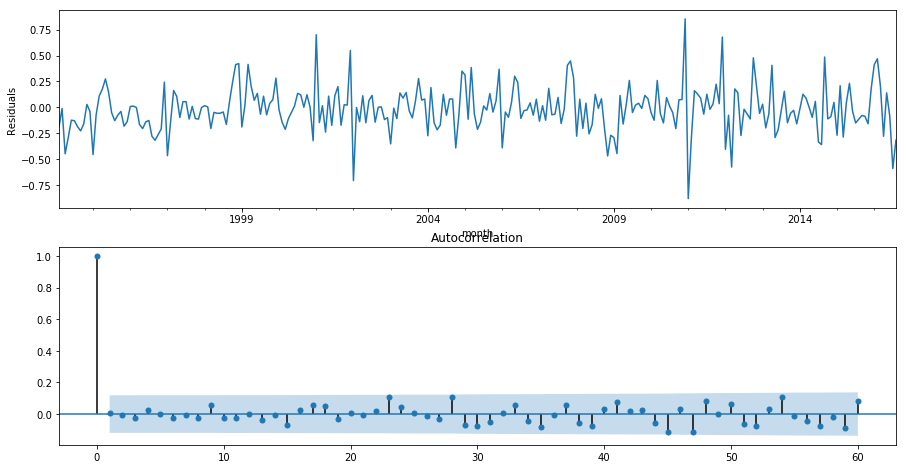

In [20]:
# остатки для лучшей модели
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=60, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента = 0.17 > 0.05) стационарны (подтверждается критерием Дики-Фуллера = 0), но могут быть автокорреляции нет (Льюнг-Бокс p=0.97 >> 0.05).

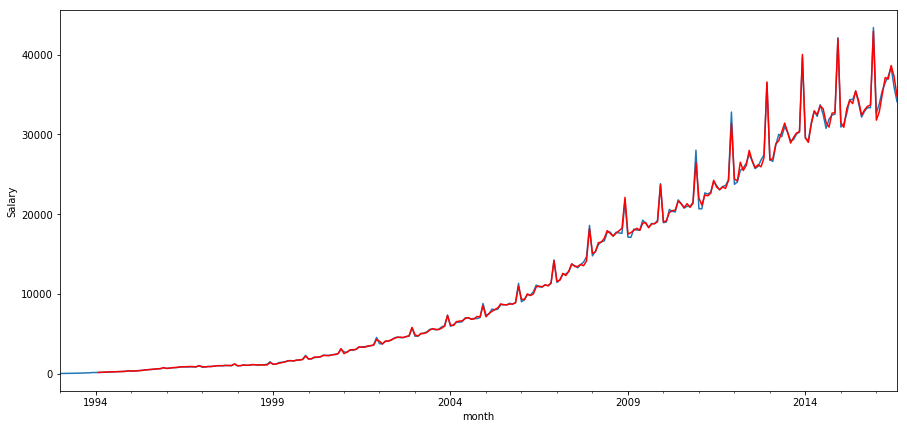

In [21]:
# Тест описательной способности модели
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color = 'r')
plt.ylabel('Salary')
pylab.show()

Видно, что модель хорошо воспроизводит исходный ряд. 
Построим прогноз на 3 года вперёд от последней доступной даты.

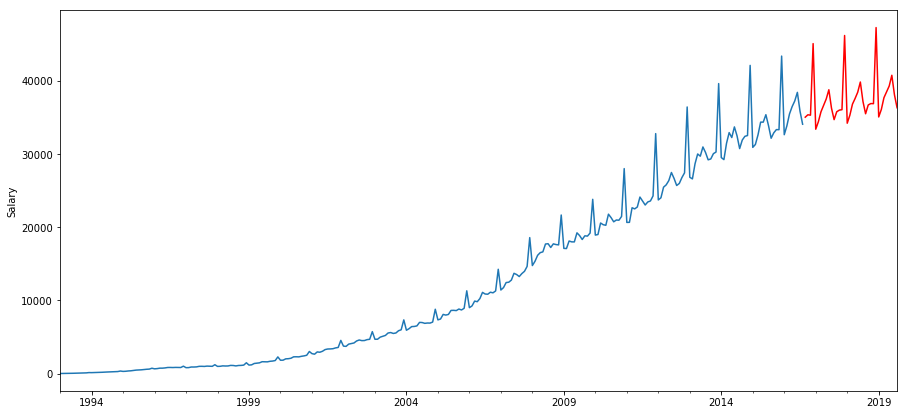

In [22]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + 
             relativedelta(months = x) for x in range(0, 36)]
future = pd.DataFrame(index = date_list, columns = data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start = data.shape[0], 
                                                 end = data.shape[0] + 35), 
                              lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

Прогноз выглядит адекватным реальности